In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time, datetime

In [3]:
def timeit(f, caption=""):
    now=time.time()
    r=f()
    duration = duration = str(datetime.timedelta(seconds=time.time()-now))
    print(caption+(" - " if(len(caption)>0) else "")+duration)
    return r

# trip_total distribution

In [79]:
def get_distribution(label, table, unique_key, num_buckets, min_value, max_value):
    df_total = pd.read_gbq(f"select count(*) as c, count(distinct({unique_key})) as duk from `{table}` ")
    total_trips = df_total["c"].values[0]
    step = int((max_value-min_value)/num_buckets)
    query_buckets = """
    SELECT bucket, count(*) as value from (
    SELECT
    CASE """+"\n".join([
        f"""WHEN {label} >= {i} AND {label} < {i+step} THEN CONCAT("{str(pos).zfill(2)} _ ", "{i}-{i+step}") """
        for pos,i in enumerate(range(min_value,max_value,step))
    ])+f""" END AS bucket
    from `{table}`
    WHERE {label} < {max_value} AND {label} >= {min_value}
    ) GROUP BY bucket order by bucket
    """
    df_buckets = timeit( lambda: pd.read_gbq(query_buckets))
    df_buckets["position"   ] = df_buckets["bucket"].str.split(" _ ").str[0]
    df_buckets["min_limit"  ] = df_buckets["bucket"].str.split(" _ ").str[1].str.split("-").str[0].apply(float).apply(int)
    df_buckets["max_limit"  ] = df_buckets["bucket"].str.split(" _ ").str[1].str.split("-").str[1].apply(float).apply(int)
    df_buckets["bucket_name"] = df_buckets["min_limit"].apply(str) + " - " + df_buckets["max_limit"].apply(str)
    return df_buckets
    
def get_comparison(label, table, unique_key, num_buckets, min_value, max_value):
    label_distr=get_distribution(
        label=label, 
        table="mlteam-ml-specialization-2021.models_results.TaxiTripTotalReduced2017V1_20210503V01", 
        unique_key="unique_key", 
        num_buckets=num_buckets, 
        min_value=min_value, 
        max_value=max_value
    )
    
    pred_distr=get_distribution(
        label="prediction", 
        table="mlteam-ml-specialization-2021.models_results.TaxiTripTotalReduced2017V1_20210503V01", 
        unique_key="unique_key", 
        num_buckets=num_buckets, 
        min_value=min_value, 
        max_value=max_value
    )
    total_distr = label_distr.set_index("bucket").join(pred_distr[["bucket","value"]].set_index("bucket"),  lsuffix='_label', rsuffix='_pred').reset_index()
    return total_distr


def get_cm(label, table, unique_key, num_buckets, min_value, max_value):
    df_total = pd.read_gbq(f"select count(*) as c, count(distinct({unique_key})) as duk from `{table}` ")
    total_trips = df_total["c"].values[0]
    step = int((max_value-min_value)/num_buckets)
    query_buckets = """
    SELECT bucket_label, bucket_pred, count(*) as value from (
    SELECT
    CASE """+"\n".join([
        f"""WHEN {label} >= {i} AND {label} < {i+step} THEN CONCAT("{str(pos).zfill(2)} _ ", "{i}-{i+step}") """
        for pos,i in enumerate(range(min_value,max_value,step))
    ])+f""" END AS bucket_label,
    CASE """+"\n".join([
        f"""WHEN prediction >= {i} AND prediction < {i+step} THEN CONCAT("{str(pos).zfill(2)} _ ", "{i}-{i+step}") """
        for pos,i in enumerate(range(min_value,max_value,step))
    ])+f""" END AS bucket_pred,
    from `{table}`
    WHERE {label} < {max_value} AND {label} >= {min_value}
    ) GROUP BY 1,2 order by 1,2
    """
    df_buckets = timeit( lambda: pd.read_gbq(query_buckets))
    df_buckets["min_limit_label"  ] = df_buckets["bucket_label"].str.split(" _ ").str[1].str.split("-").str[0].apply(float).apply(int)
    df_buckets["max_limit_label"  ] = df_buckets["bucket_label"].str.split(" _ ").str[1].str.split("-").str[1].apply(float).apply(int)
    df_buckets["bucket_name_label"] = df_buckets["min_limit_label"].apply(str) + " - " + df_buckets["max_limit_label"].apply(str)
    
    df_buckets["min_limit_pred"  ] = df_buckets["bucket_pred"].str.split(" _ ").str[1].str.split("-").str[0].apply(float).apply(int)
    df_buckets["max_limit_pred"  ] = df_buckets["bucket_pred"].str.split(" _ ").str[1].str.split("-").str[1].apply(float).apply(int)
    df_buckets["bucket_name_pred"] = df_buckets["min_limit_pred"].apply(str) + " - " + df_buckets["max_limit_pred"].apply(str)
    return df_buckets.pivot(index='bucket_pred', columns='bucket_label', values='value').fillna(0).astype(int)


def plot_comparison(label, table, unique_key, num_buckets, min_value, max_value, hist_figsize=(15,10), cm_figsize=(30,5)):
    total_distr = get_comparison(label, table, unique_key, num_buckets, min_value, max_value)
    total_distr.sort_values("position").set_index("bucket_name")[["value_label","value_pred"]].plot.bar(figsize=hist_figsize)
    df_cm = get_cm(label, table, unique_key, num_buckets, min_value, max_value)
    plt.figure(figsize = cm_figsize)
    sns.heatmap((df_cm/df_cm.sum()).round(decimals=2), annot=True)

0:00:01.463155
0:00:02.246778
0:00:01.753584


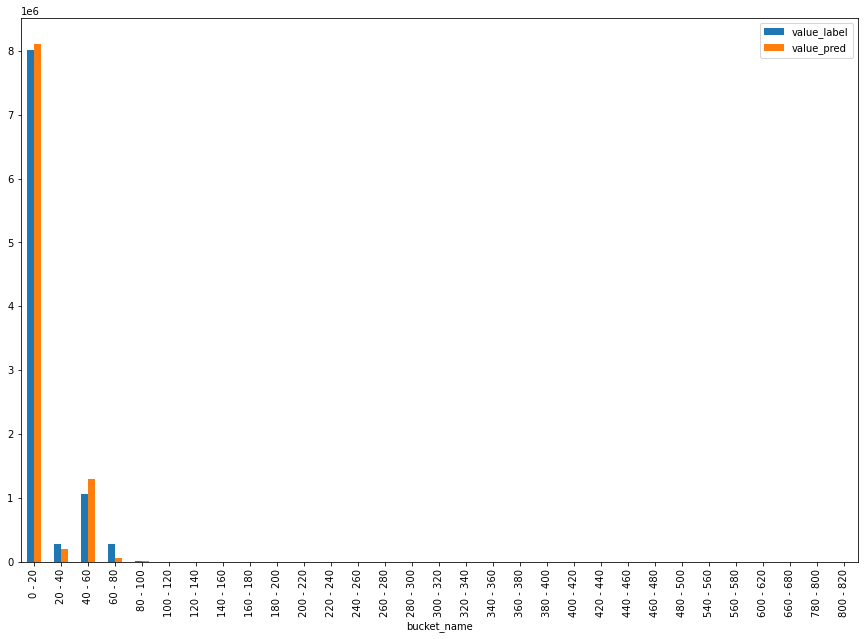

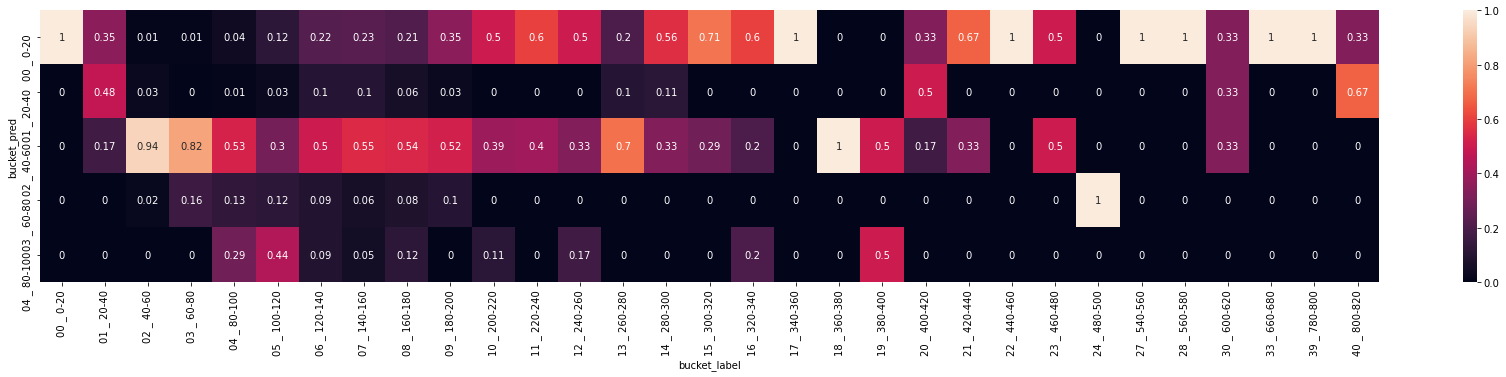

In [80]:
plot_comparison(
    label="trip_total", 
    table="mlteam-ml-specialization-2021.models_results.TaxiTripTotalReduced2017V1_20210503V01", 
    unique_key="unique_key", 
    num_buckets=50, 
    min_value=0, 
    max_value=1000
)

0:00:01.215819
0:00:04.361234
0:00:01.835887


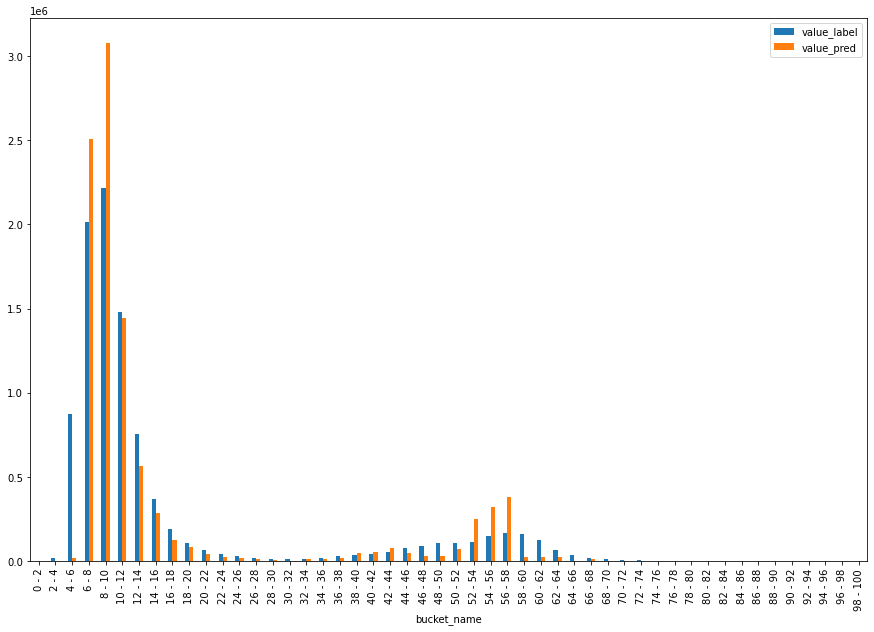

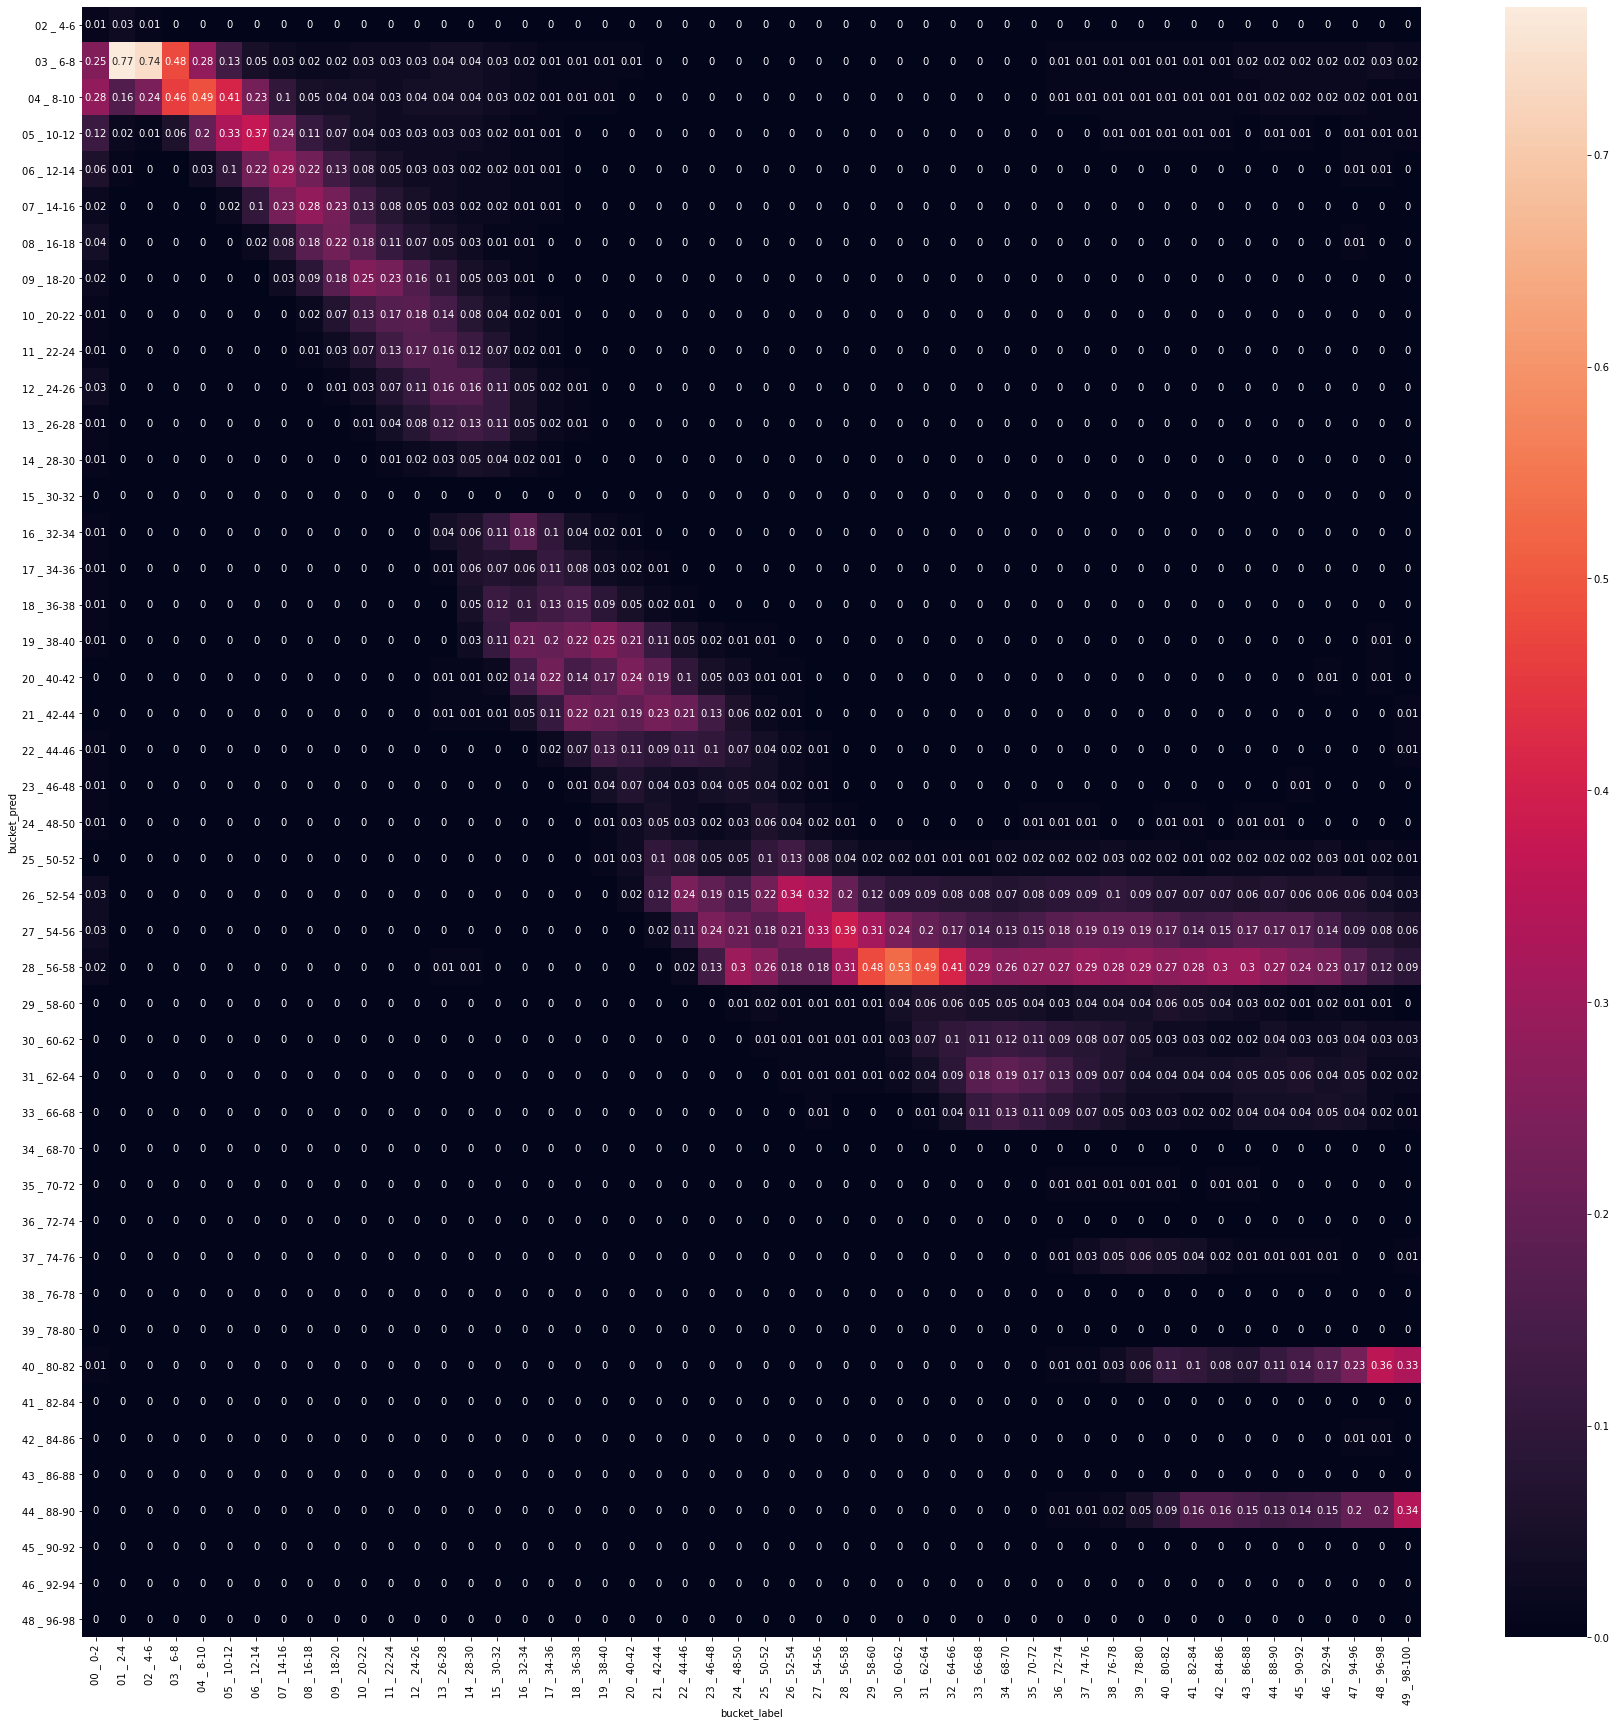

In [81]:
plot_comparison(
    label="trip_total", 
    table="mlteam-ml-specialization-2021.models_results.TaxiTripTotalReduced2017V1_20210503V01", 
    unique_key="unique_key", 
    num_buckets=50, 
    min_value=0, 
    max_value=100,
    cm_figsize=(30,30)
)

# logarithmic

In [ ]:
limits = zip(
    np.linspace(min_value,max_value,num_buckets)[:-1],
    np.linspace(min_value,max_value,num_buckets)[1:]
)

query_buckets = """
SELECT bucket, count(*) as value from (
SELECT
CASE """+"\n".join([
    f"""WHEN ln({label}) >= {i_min} AND ln({label}) < {i_max} THEN CONCAT("{str(pos).zfill(2)} _ ", "{i_min} - {i_max}") """
    for pos,(i_min,i_max) in enumerate(limits)
])+f""" END AS bucket
from `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE ln({label}) < {max_value} AND ln({label}) >= {min_value}
) GROUP BY bucket order by bucket
"""
df_buckets = timeit( lambda: pd.read_gbq(query_buckets))
df_buckets["position"   ] = df_buckets["bucket"].str.split(" _ ").str[0]
df_buckets["min_limit"  ] = df_buckets["bucket"].str.split(" _ ").str[1].str.split(" - ").str[0].apply(float).apply(lambda x: str(x)[:4])
df_buckets["max_limit"  ] = df_buckets["bucket"].str.split(" _ ").str[1].str.split(" - ").str[1].apply(float).apply(lambda x: str(x)[:4])
df_buckets["bucket_name"] = df_buckets["min_limit"].apply(str) + " - " + df_buckets["max_limit"].apply(str)
df_buckets.sort_values("position").set_index("bucket_name")["value"].plot.bar(figsize=(15,10))

In [95]:
import numpy as np

def get_distribution(label, table, unique_key, num_buckets, min_value, max_value):
    df_total = pd.read_gbq(f"select count(*) as c, count(distinct({unique_key})) as duk from `{table}` ")
    total_trips = df_total["c"].values[0]
    limits = zip(
        np.linspace(min_value,max_value,num_buckets)[:-1],
        np.linspace(min_value,max_value,num_buckets)[1:]
    )

    query_buckets = """
    SELECT bucket, count(*) as value from (
    SELECT
    CASE """+"\n".join([
        f"""WHEN ln({label}) >= {i_min} AND ln({label}) < {i_max} THEN CONCAT("{str(pos).zfill(2)} _ ", "{i_min} - {i_max}") """
        for pos,(i_min,i_max) in enumerate(limits)
    ])+f""" END AS bucket
    from `{table}`
    WHERE ln({label}) < {max_value} AND ln({label}) >= {min_value}
    AND {label} > 0
    ) GROUP BY bucket order by bucket
    """
    df_buckets = timeit( lambda: pd.read_gbq(query_buckets))
    df_buckets["position"   ] = df_buckets["bucket"].str.split(" _ ").str[0]
    df_buckets["min_limit"  ] = df_buckets["bucket"].str.split(" _ ").str[1].str.split(" - ").str[0].apply(float).round(decimals=2)
    df_buckets["max_limit"  ] = df_buckets["bucket"].str.split(" _ ").str[1].str.split(" - ").str[1].apply(float).round(decimals=2)
    df_buckets["bucket_name"] = df_buckets["min_limit"].apply(str) + " - " + df_buckets["max_limit"].apply(str)
    return df_buckets
    
def get_comparison(label, table, unique_key, num_buckets, min_value, max_value):
    label_distr=get_distribution(
        label=label, 
        table="mlteam-ml-specialization-2021.models_results.TaxiTripTotalReduced2017V1_20210503V01", 
        unique_key="unique_key", 
        num_buckets=num_buckets, 
        min_value=min_value, 
        max_value=max_value
    )
    
    pred_distr=get_distribution(
        label="prediction", 
        table="mlteam-ml-specialization-2021.models_results.TaxiTripTotalReduced2017V1_20210503V01", 
        unique_key="unique_key", 
        num_buckets=num_buckets, 
        min_value=min_value, 
        max_value=max_value
    )
    total_distr = label_distr.set_index("bucket").join(pred_distr[["bucket","value"]].set_index("bucket"),  lsuffix='_label', rsuffix='_pred').reset_index()
    return total_distr


def get_cm(label, table, unique_key, num_buckets, min_value, max_value):
    df_total = pd.read_gbq(f"select count(*) as c, count(distinct({unique_key})) as duk from `{table}` ")
    total_trips = df_total["c"].values[0]
    limits = list(zip(
        np.linspace(min_value,max_value,num_buckets)[:-1],
        np.linspace(min_value,max_value,num_buckets)[1:]
    ))
    query_buckets = """
    SELECT bucket_label, bucket_pred, count(*) as value from (
    SELECT
    CASE """+"\n".join([
        f"""WHEN ln({label}) >= {i_min} AND ln({label}) < {i_max} THEN CONCAT("{str(pos).zfill(2)} _ ", "{i_min} - {i_max}") """
        for pos,(i_min,i_max) in enumerate(limits)
    ])+f""" END AS bucket_label,
    CASE """+"\n".join([
        f"""WHEN ln(prediction) >= {i_min} AND ln(prediction) < {i_max} THEN CONCAT("{str(pos).zfill(2)} _ ", "{i_min} - {i_max}") """
        for pos,(i_min,i_max) in enumerate(limits)
    ])+f""" END AS bucket_pred,
    from `{table}`
    WHERE {label} < {max_value} AND {label} >= {min_value}
    AND {label} > 0
    AND prediction > 0
    ) GROUP BY 1,2 order by 1,2
    """
    df_buckets = timeit( lambda: pd.read_gbq(query_buckets))
    df_buckets["position_label"   ] = df_buckets["bucket_label"].str.split(" _ ").str[0]
    df_buckets["min_limit_label"  ] = df_buckets["bucket_label"].str.split(" _ ").str[1].str.split(" - ").str[0].apply(float).round(decimals=2)
    df_buckets["max_limit_label"  ] = df_buckets["bucket_label"].str.split(" _ ").str[1].str.split(" - ").str[1].apply(float).round(decimals=2)
    df_buckets["bucket_name_label"] = df_buckets["min_limit_label"].apply(str) + " - " + df_buckets["max_limit_label"].apply(str)
    
    
    df_buckets["position_pred"   ] = df_buckets["bucket_pred"].str.split(" _ ").str[0]
    df_buckets["min_limit_pred"  ] = df_buckets["bucket_pred"].str.split(" _ ").str[1].str.split(" - ").str[0].apply(float).round(decimals=2)
    df_buckets["max_limit_pred"  ] = df_buckets["bucket_pred"].str.split(" _ ").str[1].str.split(" - ").str[1].apply(float).round(decimals=2)
    df_buckets["bucket_name_pred"] = df_buckets["min_limit_pred"].apply(str) + " - " + df_buckets["max_limit_pred"].apply(str)
    return df_buckets.pivot(index='bucket_pred', columns='bucket_label', values='value').fillna(0).astype(int)


def plot_comparison(label, table, unique_key, num_buckets, min_value, max_value, hist_figsize=(15,10), cm_figsize=(30,5)):
    total_distr = get_comparison(label, table, unique_key, num_buckets, min_value, max_value)
    total_distr.sort_values("position").set_index("bucket_name")[["value_label","value_pred"]].plot.bar(figsize=hist_figsize)
    df_cm = get_cm(label, table, unique_key, num_buckets, min_value, max_value)
    plt.figure(figsize = cm_figsize)
    sns.heatmap((df_cm/df_cm.sum()).round(decimals=2), annot=True)

0:00:16.704099
0:00:17.493394
0:00:19.436165


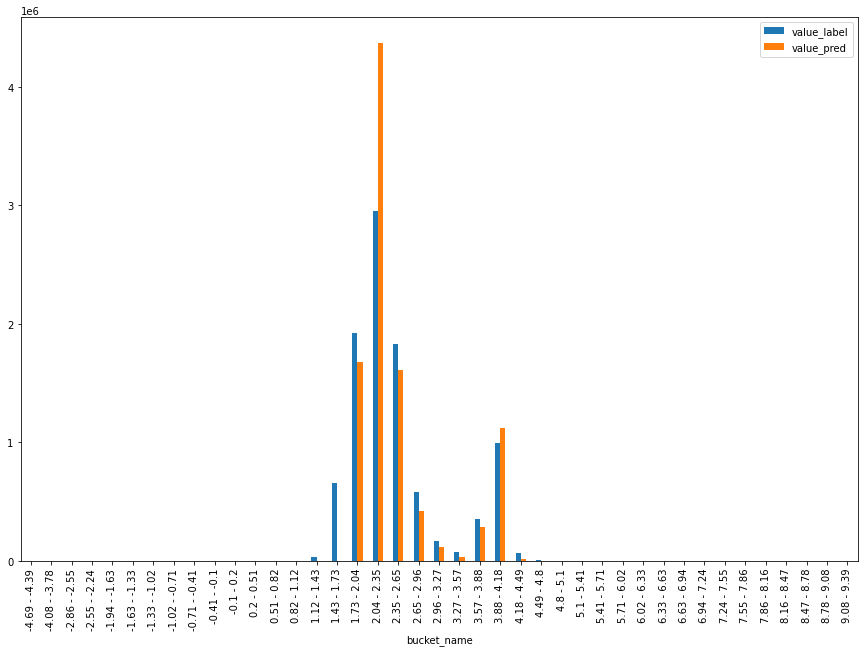

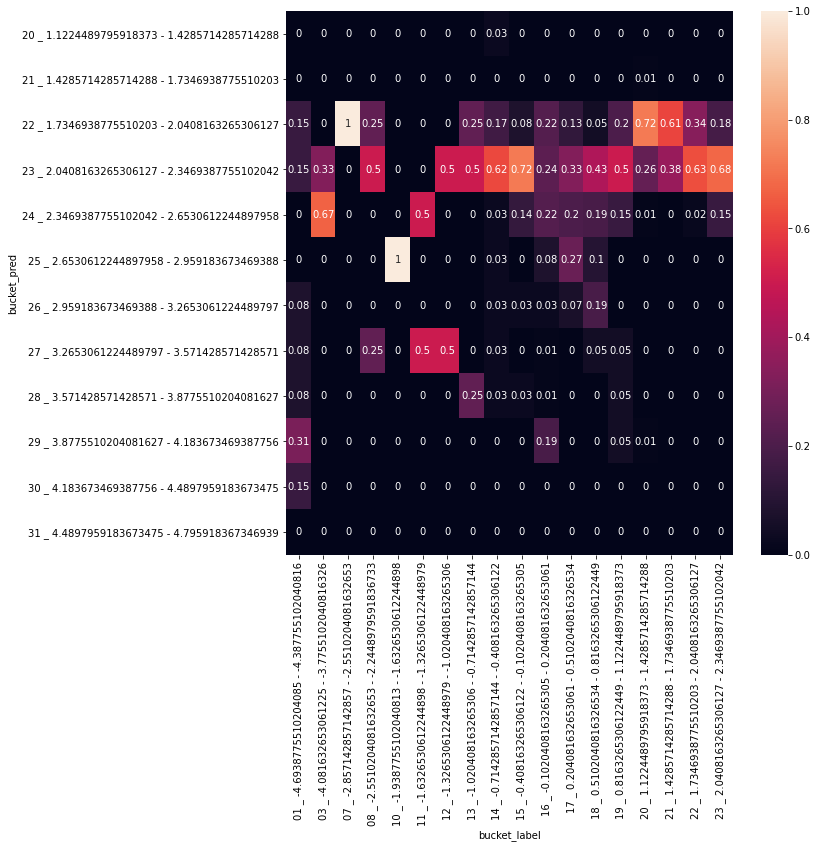

In [98]:
plot_comparison(
    label="trip_total", 
    table="mlteam-ml-specialization-2021.models_results.TaxiTripTotalReduced2017V1_20210503V01", 
    unique_key="unique_key", 
    num_buckets=50, 
    min_value=-5, 
    max_value=10,
    cm_figsize=(10,10)
)